In [1]:
import sys

sys.path.append("../")

In [2]:
import torch
import pandas as pd
import numpy as np

import simulation
from utils import set_random_seed_all
from train_utils import (
    create_intervention_dataset,
    subset_interventions,
)

from models import SDCI

In [3]:
import os
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [4]:
n, d = 100, 50
n_edges = d * 5
frac_interventions = 1.0
knockdown_eff = 1.0

B_true = simulation.simulate_dag(d, n_edges, "ER")
X_obs, _ = simulation.simulate_nonlinear_sem(B_true, n, sem_type="mlp")
# X_full_df, param_dict = simulation.generate_full_interventional_set(
#     B_true, n, "mlp", knockdown_eff=knockdown_eff, size_observational=n * (d + 1)
# )
# n_interventions = int(frac_interventions * d)
# X_df = subset_interventions(
#     X_full_df, n_interventions, maintain_dataset_size=True
# )

In [5]:
print(X_obs.shape)

(100, 50)


In [6]:
import igraph as ig

In [7]:
G = ig.Graph.Adjacency(B_true.tolist())
ordered_vertices = G.topological_sorting()

In [8]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Topological rank')

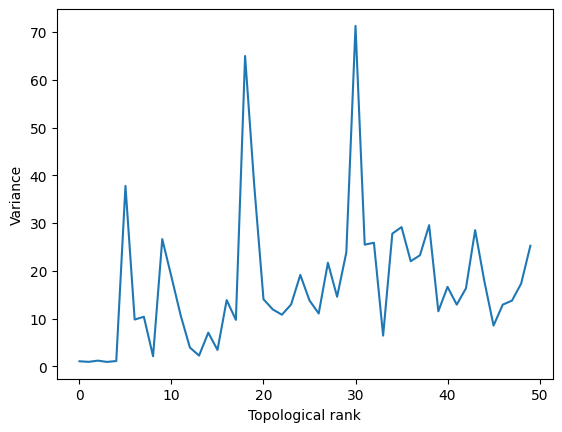

In [9]:
# topo sort
plt.plot(X_obs.var(axis=0)[ordered_vertices])
plt.ylabel("Variance")
plt.xlabel("Topological rank")

Text(0, 0.5, 'Variance(downstream_gene) - Variance(upstream_gene)')

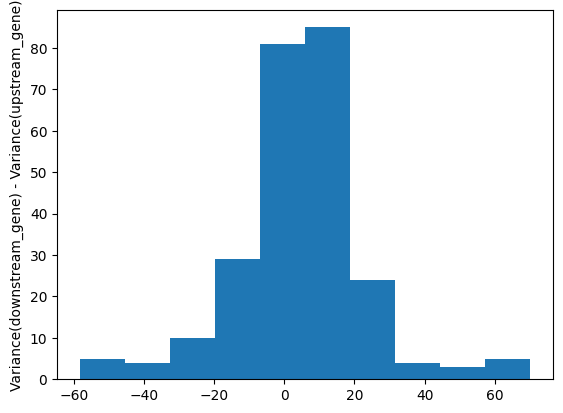

In [10]:
# plot distribution of var diff over true edges (pos means in favored dir)
variances = X_obs.var(axis=0)
var_diffs = []
for i, j in zip(*np.where(B_true)):
    var_diffs.append(variances[j] - variances[i])
plt.hist(var_diffs)
plt.ylabel("Variance(downstream_gene) - Variance(upstream_gene)")

In [11]:
# Reversed noise scale
frac_interventions = 1.0
knockdown_eff = 1.0

B_true = simulation.simulate_dag(d, n_edges, "ER")
G = ig.Graph.Adjacency(B_true.tolist())
ordered_vertices = G.topological_sorting()
noise_scale = (np.max(ordered_vertices) - np.argsort(ordered_vertices) + 1) / d * 5
X_full_df, param_dict = simulation.generate_full_interventional_set(
    B_true, n, "mlp", knockdown_eff=knockdown_eff, size_observational=n * (d + 1), noise_scale=noise_scale
)

In [12]:
X_obs = X_full_df[X_full_df["perturbation_label"] == "obs"].to_numpy()[:, :d]

Text(0.5, 0, 'Topological rank')

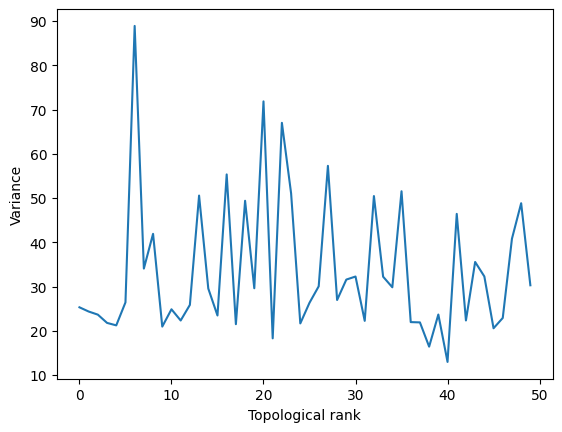

In [13]:
# topo sort
plt.plot(X_obs.var(axis=0)[ordered_vertices])
plt.ylabel("Variance")
plt.xlabel("Topological rank")

Text(0, 0.5, 'Variance(downstream_gene) - Variance(upstream_gene)')

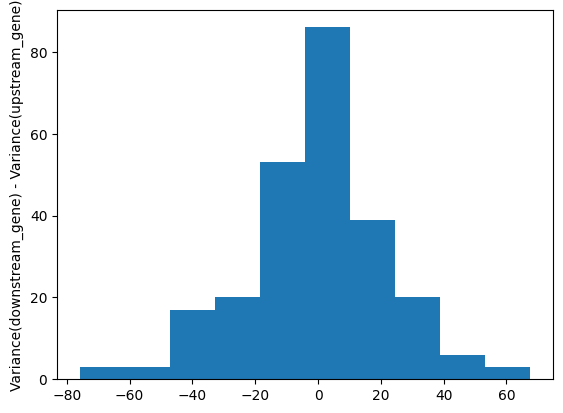

In [14]:
# plot distribution of var diff over true edges (pos means in favored dir)
variances = X_obs.var(axis=0)
var_diffs = []
for i, j in zip(*np.where(B_true)):
    var_diffs.append(variances[j] - variances[i])
plt.hist(var_diffs)
plt.ylabel("Variance(downstream_gene) - Variance(upstream_gene)")

In [20]:
# Try SDCI w/ varying perturbation fractions
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

# metrics_df_records = []
for perturbation_frac in [0, 0.5, 1.0]:
#     for mv_flavor in ["unit", "nn", "parameter"]:
    for mv_flavor in ["parameter"]:
        for standard_scale in [False]:
            for alpha_mult in [.001, .0001]:
                n_interventions = int(d * perturbation_frac)
                X_df = subset_interventions(
                    X_full_df, n_interventions, maintain_dataset_size=True
                )
                dataset = create_intervention_dataset(X_df, regime_format=False)

                model = SDCI(model_variance_flavor=mv_flavor, standard_scale=standard_scale)
                model.train(
                    dataset,
                    B_true=B_true,
                    device=device,
                    log_wandb=True,
                    wandb_config_dict={"model_variance_flavor": mv_flavor, "perturbation_frac": perturbation_frac},
                    verbose=False,
                    stage1_kwargs={"n_epochs": 1000, "alpha": 1e-2 * alpha_mult},
                    stage2_kwargs={"n_epochs": 1000, "alpha": 5e-3 * alpha_mult}
                )
                metrics_dict = model.compute_metrics(B_true)
                metrics_dict["model_variance_flavor"] = mv_flavor
                metrics_dict["standard_scale"] = standard_scale
                metrics_dict["alpha_mult"] = alpha_mult
                metrics_dict["mask_recall"] =  (B_true.astype(bool) & model._mask.astype(bool)).sum() / B_true.sum()
                metrics_dict["train_time"] = model._train_runtime_in_sec
                metrics_dict["n_interventions"] = n_interventions
                metrics_df_records.append(metrics_dict)


Using cuda:0


alpha,██████████▁▁▁▁▁▁▁▁▁▁
dag,▁▁▁▁▁▁▁▁▁▁█▄▃▃▃▃▃▃▃▃
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_loss,█▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁
gamma,▁▁▁▁▁▁▁▁▁▁▁█████████
is_prescreen,██████████▁▁▁▁▁▁▁▁▁▁
l1,▂▇██▇▆▆▆▆▆▂▁▁▁▁▁▁▁▁▁
l2,▁▄▆▇▇▇████▁▆▇▇██████
n_edges_pred,▁▆██▇▆▆▆▅▅▆▂▁▁▁▁▁▁▁▁
nll,█▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁
precision,▁▄▃▃▄▄▄▄▄▄▃█████████


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=2193.92, score=250, shd=250.0, gamma=0.00
Epoch 100: loss=225.20, score=587, shd=587.0, gamma=0.00
Epoch 200: loss=165.23, score=963, shd=963.0, gamma=0.00
Epoch 300: loss=151.37, score=1014, shd=1014.0, gamma=0.00
Epoch 400: loss=146.29, score=897, shd=897.0, gamma=0.00
Epoch 500: loss=144.78, score=762, shd=762.0, gamma=0.00
Epoch 600: loss=144.45, score=693, shd=693.0, gamma=0.00
Epoch 700: loss=144.34, score=683, shd=683.0, gamma=0.00
Epoch 800: loss=144.30, score=687, shd=687.0, gamma=0.00
Epoch 900: loss=144.28, score=690, shd=690.0, gamma=0.00
Recall of mask: 0.996
Fraction of possible edges in mask: 0.7408
Epoch 0: loss=292570433863653758756454400.00, score=542, shd=542.0, gamma=0.00
Epoch 100: loss=292570433863653758756454400.00, score=210, shd=210.0, gamma=30.03
Epoch 200: loss=292570433863653758756454400.00, score=225, shd=225.0, gamma=30.03
Epoch 300: loss=292570433863653758756454400.00, score=223, shd=223.0, gamma=30.03
Epoch 400: loss=29257043386365375875645

alpha,██████████▁▁▁▁▁▁▁▁▁▁
dag,▁▁▁▁▁▁▁▁▁▁█▃▃▃▂▂▂▂▂▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_loss,▁▁▁▁▁▁▁▁▁▁██████████
gamma,▁▁▁▁▁▁▁▁▁▁▁█████████
is_prescreen,██████████▁▁▁▁▁▁▁▁▁▁
l1,▁▇███▇▇▇▇▇▂▁▁▁▁▁▁▁▁▁
l2,▁▁▁▁▁▁▁▁▁▁██████████
n_edges_pred,▁▅██▇▇▆▆▆▆▄▁▁▁▁▁▁▁▁▁
nll,█▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁
precision,▁▃▃▂▃▃▃▃▃▃▃▇▇█▇▇█▇██


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=2145.09, score=250, shd=250.0, gamma=0.00
Epoch 100: loss=213.48, score=577, shd=577.0, gamma=0.00
Epoch 200: loss=163.18, score=953, shd=953.0, gamma=0.00
Epoch 300: loss=150.43, score=968, shd=968.0, gamma=0.00
Epoch 400: loss=145.76, score=829, shd=829.0, gamma=0.00
Epoch 500: loss=144.21, score=717, shd=717.0, gamma=0.00
Epoch 600: loss=143.96, score=658, shd=658.0, gamma=0.00
Epoch 700: loss=143.89, score=656, shd=656.0, gamma=0.00
Epoch 800: loss=143.84, score=662, shd=662.0, gamma=0.00
Epoch 900: loss=143.78, score=661, shd=661.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.7232
Epoch 0: loss=1955.97, score=565, shd=565.0, gamma=0.00
Epoch 100: loss=182.10, score=209, shd=209.0, gamma=30.03
Epoch 200: loss=169.81, score=223, shd=223.0, gamma=30.03
Epoch 300: loss=166.78, score=230, shd=230.0, gamma=30.03
Epoch 400: loss=166.42, score=231, shd=231.0, gamma=30.03
Epoch 500: loss=166.28, score=232, shd=232.0, gamma=30.03
Epoch 600: loss=166.37

alpha,██████████▁▁▁▁▁▁▁▁▁▁
dag,▁▁▁▁▁▁▁▁▁▁█▃▃▃▂▂▂▂▂▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_loss,█▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁
gamma,▁▁▁▁▁▁▁▁▁▁▁█████████
is_prescreen,██████████▁▁▁▁▁▁▁▁▁▁
l1,▁▇███▇▇▇▇▇▂▁▁▁▁▁▁▁▁▁
l2,▁▅▆▇██████▁▆▇███████
n_edges_pred,▁▆██▇▇▆▆▆▆▄▁▁▁▁▁▁▁▁▁
nll,█▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁
precision,▁▃▃▃▃▃▃▃▃▃▃▇█▇▇▇███▇


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=2130.66, score=250, shd=250.0, gamma=0.00
Epoch 100: loss=214.07, score=581, shd=581.0, gamma=0.00
Epoch 200: loss=162.97, score=988, shd=988.0, gamma=0.00
Epoch 300: loss=149.95, score=980, shd=980.0, gamma=0.00
Epoch 400: loss=145.21, score=853, shd=853.0, gamma=0.00
Epoch 500: loss=143.72, score=732, shd=732.0, gamma=0.00
Epoch 600: loss=143.40, score=677, shd=677.0, gamma=0.00
Epoch 700: loss=143.34, score=662, shd=662.0, gamma=0.00
Epoch 800: loss=143.27, score=671, shd=671.0, gamma=0.00
Epoch 900: loss=143.23, score=682, shd=682.0, gamma=0.00
Recall of mask: 0.996
Fraction of possible edges in mask: 0.746
Epoch 0: loss=1907.81, score=532, shd=532.0, gamma=0.00
Epoch 100: loss=181.05, score=203, shd=203.0, gamma=30.03
Epoch 200: loss=168.77, score=219, shd=219.0, gamma=30.03
Epoch 300: loss=166.60, score=221, shd=221.0, gamma=30.03
Epoch 400: loss=165.63, score=226, shd=226.0, gamma=30.03
Epoch 500: loss=165.44, score=228, shd=228.0, gamma=30.03
Epoch 600: loss=165.5

alpha,██████████▁▁▁▁▁▁▁▁▁▁
dag,▁▁▁▁▁▁▁▁▁▁█▃▃▃▂▂▂▂▂▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_loss,█▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁
gamma,▁▁▁▁▁▁▁▁▁▁▁█████████
is_prescreen,██████████▁▁▁▁▁▁▁▁▁▁
l1,▁▇██▇▇▇▇▇▇▂▁▁▁▁▁▁▁▁▁
l2,▁▄▆▇██████▁▆▇▇██████
n_edges_pred,▁▆██▇▇▆▆▆▆▄▁▁▁▁▁▁▁▁▁
nll,█▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁
precision,▁▃▃▃▃▃▃▃▃▃▃█████████


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=2111.72, score=250, shd=250.0, gamma=0.00
Epoch 100: loss=215.17, score=587, shd=587.0, gamma=0.00
Epoch 200: loss=162.30, score=963, shd=963.0, gamma=0.00
Epoch 300: loss=149.64, score=1004, shd=1004.0, gamma=0.00
Epoch 400: loss=144.81, score=844, shd=844.0, gamma=0.00
Epoch 500: loss=143.36, score=733, shd=733.0, gamma=0.00
Epoch 600: loss=143.06, score=675, shd=675.0, gamma=0.00
Epoch 700: loss=142.97, score=663, shd=663.0, gamma=0.00
Epoch 800: loss=142.94, score=670, shd=670.0, gamma=0.00
Epoch 900: loss=142.90, score=687, shd=687.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.7416
Epoch 0: loss=1902.22, score=544, shd=544.0, gamma=0.00
Epoch 100: loss=181.52, score=206, shd=206.0, gamma=30.03
Epoch 200: loss=169.00, score=217, shd=217.0, gamma=30.03
Epoch 300: loss=166.30, score=223, shd=223.0, gamma=30.03
Epoch 400: loss=165.84, score=227, shd=227.0, gamma=30.03
Epoch 500: loss=165.86, score=228, shd=228.0, gamma=30.03
Epoch 600: loss=165.

alpha,██████████▁▁▁▁▁▁▁▁▁▁
dag,▁▁▁▁▁▁▁▁▁▁█▃▃▃▂▂▂▂▂▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_loss,█▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁
gamma,▁▁▁▁▁▁▁▁▁▁▁█████████
is_prescreen,██████████▁▁▁▁▁▁▁▁▁▁
l1,▁▇███▇▇▇▇▇▂▁▁▁▁▁▁▁▁▁
l2,▁▅▆▇▇█████▁▆▇▇██████
n_edges_pred,▁▆██▇▆▆▆▆▆▄▁▁▁▁▁▁▁▁▁
nll,█▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁
precision,▁▃▂▂▃▃▃▃▃▃▃▇▇██▇▇█▇█


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=2163.46, score=250, shd=250.0, gamma=0.00
Epoch 100: loss=216.93, score=571, shd=571.0, gamma=0.00
Epoch 200: loss=162.91, score=963, shd=963.0, gamma=0.00
Epoch 300: loss=149.41, score=985, shd=985.0, gamma=0.00
Epoch 400: loss=144.51, score=863, shd=863.0, gamma=0.00
Epoch 500: loss=143.01, score=747, shd=747.0, gamma=0.00
Epoch 600: loss=142.63, score=669, shd=669.0, gamma=0.00
Epoch 700: loss=142.57, score=666, shd=666.0, gamma=0.00
Epoch 800: loss=142.56, score=669, shd=669.0, gamma=0.00
Epoch 900: loss=142.51, score=684, shd=684.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.7328
Epoch 0: loss=1920.05, score=537, shd=537.0, gamma=0.00
Epoch 100: loss=180.27, score=208, shd=208.0, gamma=30.03
Epoch 200: loss=168.12, score=216, shd=216.0, gamma=30.03
Epoch 300: loss=165.45, score=221, shd=221.0, gamma=30.03
Epoch 400: loss=164.39, score=225, shd=225.0, gamma=30.03
Epoch 500: loss=164.73, score=229, shd=229.0, gamma=30.03
Epoch 600: loss=164.71

alpha,██████████▁▁▁▁▁▁▁▁▁▁
dag,▁▁▁▁▁▁▁▁▁▁█▃▃▃▂▂▂▂▂▂
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_loss,█▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁
gamma,▁▁▁▁▁▁▁▁▁▁▁█████████
is_prescreen,██████████▁▁▁▁▁▁▁▁▁▁
l1,▁▇███▇▇▇▇▇▂▁▁▁▁▁▁▁▁▁
l2,▁▅▆▇██████▁▆▇███████
n_edges_pred,▁▆██▇▇▆▆▆▆▄▁▁▁▁▁▁▁▁▁
nll,█▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁
precision,▁▃▃▃▃▃▃▃▃▃▃▇████████


/home/justin/miniconda3/envs/cp/lib/python3.9/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 0: loss=2138.92, score=250, shd=250.0, gamma=0.00
Epoch 100: loss=217.03, score=562, shd=562.0, gamma=0.00
Epoch 200: loss=162.87, score=953, shd=953.0, gamma=0.00
Epoch 300: loss=149.42, score=988, shd=988.0, gamma=0.00
Epoch 400: loss=144.50, score=847, shd=847.0, gamma=0.00
Epoch 500: loss=142.96, score=720, shd=720.0, gamma=0.00
Epoch 600: loss=142.61, score=652, shd=652.0, gamma=0.00
Epoch 700: loss=142.57, score=653, shd=653.0, gamma=0.00
Epoch 800: loss=142.48, score=650, shd=650.0, gamma=0.00
Epoch 900: loss=142.41, score=654, shd=654.0, gamma=0.00
Recall of mask: 1.0
Fraction of possible edges in mask: 0.7184
Epoch 0: loss=1867.49, score=527, shd=527.0, gamma=0.00
Epoch 100: loss=179.43, score=204, shd=204.0, gamma=30.03
Epoch 200: loss=167.42, score=214, shd=214.0, gamma=30.03
Epoch 300: loss=164.91, score=222, shd=222.0, gamma=30.03
Epoch 400: loss=164.43, score=225, shd=225.0, gamma=30.03
Epoch 500: loss=164.39, score=226, shd=226.0, gamma=30.03
Epoch 600: loss=164.20

In [21]:
metrics_df = pd.DataFrame.from_records(metrics_df_records)
metrics_df

,score,shd,precision,recall,n_edges_pred,model_variance_flavor,standard_scale,alpha_mult,mask_recall,train_time,n_interventions
0,238,238.0,1.000000,0.048,12,unit,True,1.0000,0.544,72.380897,0
1,239,239.0,1.000000,0.044,11,unit,True,0.5000,0.604,70.439824,0
2,243,243.0,1.000000,0.028,7,unit,True,0.1000,0.712,71.148212,0
3,122,122.0,0.813725,0.664,204,unit,False,1.0000,0.992,71.356779,0
4,187,187.0,0.838710,0.312,93,unit,False,0.5000,1.000,70.638274,0
5,159,159.0,0.740741,0.560,189,unit,False,0.1000,1.000,72.064594,0
6,233,233.0,0.814815,0.088,27,nn,True,1.0000,0.720,81.446967,0
7,232,232.0,0.875000,0.084,24,nn,True,0.5000,0.852,79.474606,0
8,242,242.0,0.785714,0.044,14,nn,True,0.1000,0.976,82.526701,0
9,226,226.0,0.928571,0.104,28,nn,False,1.0000,0.808,80.703981,0


In [23]:
metrics_df.sort_values("n_edges_pred")

,score,shd,precision,recall,n_edges_pred,model_variance_flavor,standard_scale,alpha_mult,mask_recall,train_time,n_interventions
2,243,243.0,1.000000,0.028,7,unit,True,0.1000,0.712,71.148212,0
38,242,242.0,1.000000,0.032,8,unit,True,0.1000,0.744,74.253122,50
20,242,242.0,1.000000,0.032,8,unit,True,0.1000,0.724,71.819372,25
1,239,239.0,1.000000,0.044,11,unit,True,0.5000,0.604,70.439824,0
19,239,239.0,1.000000,0.044,11,unit,True,0.5000,0.600,72.823613,25
0,238,238.0,1.000000,0.048,12,unit,True,1.0000,0.544,72.380897,0
14,244,244.0,0.750000,0.036,12,parameter,True,0.1000,0.968,76.346350,0
44,240,240.0,0.857143,0.048,14,nn,True,0.1000,0.976,81.905638,50
37,236,236.0,1.000000,0.056,14,unit,True,0.5000,0.608,67.594080,50
8,242,242.0,0.785714,0.044,14,nn,True,0.1000,0.976,82.526701,0


In [25]:
metrics_df.sort_values("score")

,score,shd,precision,recall,n_edges_pred,model_variance_flavor,standard_scale,alpha_mult,mask_recall,train_time,n_interventions
3,122,122.0,0.813725,0.664,204,unit,False,1.0000,0.992,71.356779,0
39,130,130.0,0.797030,0.644,202,unit,False,1.0000,0.992,70.655085,50
5,159,159.0,0.740741,0.560,189,unit,False,0.1000,1.000,72.064594,0
21,164,164.0,0.905660,0.384,106,unit,False,1.0000,0.996,69.022830,25
41,177,177.0,0.892473,0.332,93,unit,False,0.1000,1.000,73.164826,50
40,179,179.0,0.865979,0.336,97,unit,False,0.5000,0.996,70.251792,50
22,181,181.0,0.870968,0.324,93,unit,False,0.5000,1.000,76.695381,25
23,183,183.0,0.868132,0.316,91,unit,False,0.1000,1.000,71.554929,25
4,187,187.0,0.838710,0.312,93,unit,False,0.5000,1.000,70.638274,0
34,209,209.0,1.000000,0.164,41,parameter,False,0.5000,0.992,73.527497,25


In [17]:
# # inspect obs inferred matrix
# X_df = subset_interventions(
#     X_full_df, 0, maintain_dataset_size=True
# )
# dataset = create_intervention_dataset(X_df, regime_format=False)

# model = SDCI(model_variance = True)
# model.train(
#     dataset,
#     B_true=B_true,
#     device=device,
#     verbose=False
# )

In [18]:
# # Plot variance diff for inferred edges
# B_hat = model.get_adjacency_matrix()
# variances = X_obs.var(axis=0)
# var_diffs = []
# for i, j in zip(*np.where(B_hat)):
#     var_diffs.append(variances[j] - variances[i])
# plt.hist(var_diffs)
# plt.ylabel("Variance(downstream_gene) - Variance(upstream_gene) in inferred B")